# Desafío - Inferencia de tópicos con EM

### Nombre: Thomas Peet, Braulio Aguila, Camilo Ramírez   
### Generación: G47   
### Profesores: Alfonso Tobar - Sebastián Ulloa   
### Fecha: 05-09-2022

### Requerimientos
* En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump.
* Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
* En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción.
* Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

### Ejercicio 1: Preparar el ambiente de trabajo
* Importe los módulos numpy, pandas, matplotlib, seaborn, glob y os siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump.
* Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
* Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import glob

In [2]:
files = glob.glob('dump/*.csv')
files

['dump\\anthrax_scrape.csv',
 'dump\\a_tribe_called_quest_scrape.csv',
 'dump\\black_star_scrape.csv',
 'dump\\bob_dylan_scrape.csv',
 'dump\\britney_spears_scrape.csv',
 'dump\\bruce_springsteen_scrape.csv',
 'dump\\cannibal_corpse_scrape.csv',
 'dump\\carly_rae_jepsen_scrape.csv',
 'dump\\deicide_scrape.csv',
 'dump\\de_la_soul_scrape.csv',
 'dump\\dr._dre_scrape.csv',
 'dump\\dua_lipa_scrape.csv',
 'dump\\eminem_scrape.csv',
 'dump\\faith_no_more_scrape.csv',
 'dump\\ghostface_killah_scrape.csv',
 'dump\\gorgoroth_scrape.csv',
 'dump\\immortal_scrape.csv',
 'dump\\incubus_scrape.csv',
 'dump\\iron_maiden_scrape.csv',
 'dump\\kanye_west_scrape.csv',
 'dump\\kendrick_lamar_scrape.csv',
 'dump\\killer_mike_scrape.csv',
 'dump\\kiss_scrape.csv',
 'dump\\led_zeppelin_scrape.csv',
 'dump\\lorde_scrape.csv',
 'dump\\mayhem_scrape.csv',
 'dump\\megadeth_scrape.csv',
 'dump\\meshuggah_scrape.csv',
 'dump\\metallica_scrape.csv',
 'dump\\method_man_scrape.csv',
 'dump\\mf_doom_scrape.csv',
 'd

In [3]:
df = pd.concat(pd.read_csv(file, header=0) for file in files).drop(columns='Unnamed: 0')
df

,0,1,2,3
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...
...,...,...,...,...
246,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n..."
247,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...
248,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...
249,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...


In [17]:
df.columns = ['artist', 'genre', 'song', 'lyrics']
df

,artist,genre,song,lyrics
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...
...,...,...,...,...
246,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n..."
247,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...
248,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...
249,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...


### Ejercicio 2: Matriz de ocurrencias
* Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de la librería sklearn.
* Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.
* Con la clase inicializada, incorpore las letras con el método fit_transform y guarde los resultados en un nuevo objeto.


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
cv = CountVectorizer(stop_words='english', max_features=5000)
df_ft= cv.fit_transform(df.lyrics)
df_ft

<9489x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 701351 stored elements in Compressed Sparse Row format>

### Ejercicio 3: Entrenamiento del Modelo
* Importe sklearn.decomposition.LatentDirichletAllocation y sklearn.model_selection.GridSearchCV.
* Genere una búsqueda de grilla con los siguientes hiper parámetros:
    * n_components: [5, 10, 15].
    * learning_decay: [0.7, 0.5].
* Entrene la búsqueda de grilla con las letras en un formato vectorizado con CountVectorizer.
* Reporte brevemente cuál es la mejor combinación de hiper parámetros.  

#### **Digresión: Latent Dirichlet Allocation**
Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia Variacional EM. La principal utilidad de esto es la identificación de tópicos en un corpus de texto. El proceso de inferencia se puede resumir en los siguientes pasos:
* Cada documento dentro del corpus se puede entender como una mezcla de tópicos comunes a nivel de corpus.
* Esta mezcla de tópicos es latente: sólo observamos los documentos registrados y sus palabras. 
 
    La API de sklearn.decomposition.LatentDirichletAllocation presenta la misma funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la inicialización de la clase son:
    * n_components: Cantidad de tópicos a inferir en un corpus.
    * learning_method: Forma en la que entran los datos en entrenamiento. Cuando es 'batch', se ingresa la matriz de entrenamiento completa. Cuando es 'online', la matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas.   
     * learning_decay: Tasa de aprendizaje en la función de pérdida. Cuando se implementa con learning_method='online', el modelo se entrena con Gradiente Estocástico Descendente.
    * Perplejidad: Busca aproximar el número óptimo de tópicos a inferir. Técnicamente evalúa qué tan bien predice una muestra específica. En función a un número de tópicos, define la distribución teórica de palabras representada por los tópicos y la compara con la ocurrencia empírica de palabras en tópicos

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [8]:
lda = LatentDirichletAllocation(n_jobs=-1, random_state=123, learning_method='online')
params = {'learning_decay': [0.7, 0.5],
          'n_components': [5,10,15]}
search = GridSearchCV(lda, param_grid = params, scoring='accuracy', n_jobs=-1)
search.fit(df_ft)
search

c:\Users\crami\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'learning_decay': [0.7, 0.5],
                         'n_components': [5, 10, 15]},
             scoring='accuracy')

In [9]:
search.best_params_

{'learning_decay': 0.7, 'n_components': 5}

### Ejercicio 4 : Inferencia e Identificación de Tópicos
* En base a la mejor combinación de hiper parámetros, entrene el modelo con la matriz de atributos de las letras.
* Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras asociadas con éste. Puede implementar la siguiente línea de código para identificar las principales palabras en un tópico:   
```` PYTHON
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(fit_best_lda.components_):
# para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamossu correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))
````
* Comente a qué tópicos está asociada cada clase inferida.

In [20]:
best_lda = LatentDirichletAllocation(n_components=5, learning_decay=0.7, n_jobs=-1, random_state=123, learning_method='online')
fit_best_lda = best_lda.fit(df_ft)
for topic_id, topic_name in enumerate(fit_best_lda.components_):
    print("tópico: {}".format(topic_id + 1))
    print(" ".join([cv.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))


tópico: 1
life ll time away ve world day eyes just like heart light way feel come
tópico: 2
don love know oh yeah just baby got want let like ll say come gonna
tópico: 3
man night oh little rock got song tonight like hey gonna said home big old
tópico: 4


c:\Users\crami\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


like got shit ain don yo nigga know fuck em cause man just ya niggas
tópico: 5
la god die death dead blood kill war life hate soul fucking power man don


>> ### Comentarios:
De acuerdo a las palabras representadas en cada uno de los tópicos, nos aventuramos en etiquetar cada uno de éstos con los siguientes géneros musicales:

- Tópico 1: Rock/Proggresive
- Tópico 2: Pop
- Tópico 3: Pop/Rock
- Tópico 4: Hip-Hop, R&B
- Tópico 5: Metal

### Ejercicio 5: Identificación de probabilidades
* En base a la información generada, es posible identificar cuales van a ser los géneros más probables de ocurrir para un artista.
* Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos original. Podemos implementar esto de la siguiente manera:  
```` PYTHON
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_lda.transform(transformed_feats)
# esta transformación la podemos coaccionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
# pasamos esta matriz y la redondeamos en 3 decimales
np.round(fit_best_lda, 3),
# agregamos un índice
index=df_lyrics.index
)
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x),
range(1, best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

````
* Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente brevemente cuales son las principales asociaciones existentes.
* Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.
* Grafique la distribución de las probabilidades para algún artista en específico

In [11]:
fit_best_lda = best_lda.transform(df_ft)

topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3), index=df.index)

topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_lda.n_components + 1)))

concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)

concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [168]:
concatenated_df.corr()

,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
T: 1,1.000000,-0.329546,-0.221117,-0.450395,0.021488,-0.623758
T: 2,-0.329546,1.000000,-0.184518,-0.343878,-0.292046,-0.272526
T: 3,-0.221117,-0.184518,1.000000,-0.236344,-0.194231,0.017996
T: 4,-0.450395,-0.343878,-0.236344,1.000000,-0.171078,0.618167
T: 5,0.021488,-0.292046,-0.194231,-0.171078,1.000000,0.338443
highest_topic,-0.623758,-0.272526,0.017996,0.618167,0.338443,1.000000


In [169]:
concatenated_df[concatenated_df['artist']=='Cannibal Corpse'].corr()

,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
T: 1,1.000000,-0.206358,0.031816,-0.084349,-0.885360,-0.727899
T: 2,-0.206358,1.000000,0.356188,0.321713,-0.184169,-0.057124
T: 3,0.031816,0.356188,1.000000,0.392705,-0.358112,-0.117258
T: 4,-0.084349,0.321713,0.392705,1.000000,-0.267539,-0.046103
T: 5,-0.885360,-0.184169,-0.358112,-0.267539,1.000000,0.734348
highest_topic,-0.727899,-0.057124,-0.117258,-0.046103,0.734348,1.000000


>> ### Comentarios:
De acuerdo a la información entregadas en la matriz de correlación para el general de nuestro DataSet:
* En el caso de una correlación muy marcada, ya sea positiva o negativa, nos demuestra que es posible que esa letra este muy bien definida a un cierto tópico con respecto a otro. Para el caso una correlación cercana a 0, nos puede dar indicios de que composición de esa canción no tiene relación alguna frente a las otras caracteristicas que definen a los otros tópicos. 

In [30]:
concatenated_df[concatenated_df['artist']=='Tool']

,artits,genre,song,lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Tool,metal,Sweat,I'm sweating and breathing \n And staring and ...,0.986,0.003,0.003,0.003,0.003,1
1,Tool,metal,Hush,Fuck you \n I can't say what I want to \n Even...,0.003,0.667,0.003,0.324,0.003,2
2,Tool,metal,Part Of Me,I know you well \n You are a part of me \n I k...,0.003,0.953,0.003,0.003,0.037,2
3,Tool,metal,Cold And Ugly,"""Throw that Bob Marley wanna-be motherfucker o...",0.771,0.135,0.003,0.089,0.003,1
4,Tool,metal,Jerk-Off,Someone told me once that \n There's a right a...,0.003,0.598,0.003,0.003,0.391,2
...,...,...,...,...,...,...,...,...,...,...
57,Tool,metal,Stranglehold,"Here I come again now, baby \n Like a dog in h...",0.079,0.688,0.002,0.229,0.002,2
58,Tool,metal,Lateralus/Fibonacci,| \n Syllable count for each line (see \n Inte...,0.803,0.002,0.139,0.002,0.055,1
59,Tool,metal,Spasm,"My, out of my mind \n My life, I \n My mind, o...",0.296,0.004,0.004,0.004,0.693,5
60,Tool,metal,Ticks And Leeches,Suck and suck. Suckin up all you can suckin up...,0.003,0.003,0.144,0.129,0.721,5


In [149]:
bands =['Dr. Dre', 'Opeth','Rage Against The Machine', 'Britney Spears', 'Cannibal Corpse']

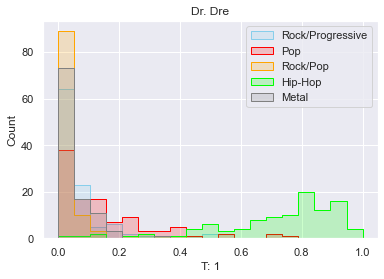

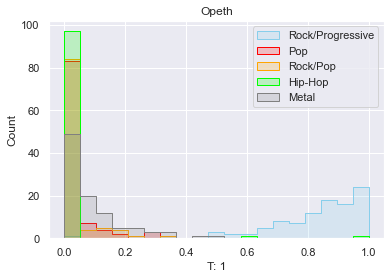

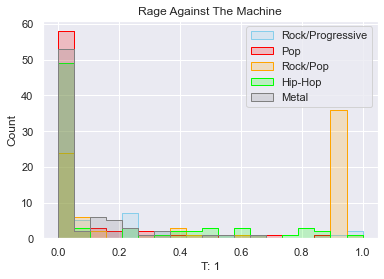

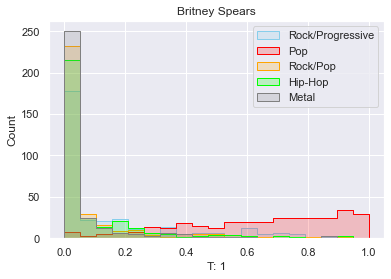

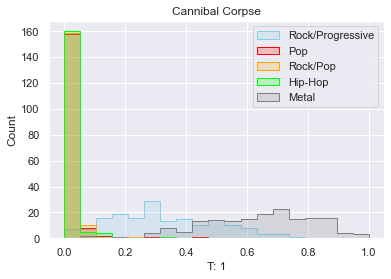

In [150]:
def graf_band(name):
    sns.histplot(x='T: 1', data= concatenated_df[concatenated_df['artist']== name], element ='step', color="skyblue", alpha = 0.2, bins=np.linspace(0,1,20), label='Rock/Progressive')
    sns.histplot(x='T: 2', data= concatenated_df[concatenated_df['artist']== name], element ='step', color="red", alpha = 0.2, bins=np.linspace(0,1,20), label='Pop')
    sns.histplot(x='T: 3', data= concatenated_df[concatenated_df['artist']== name], element ='step', color="orange", alpha = 0.2, bins=np.linspace(0,1,20), label='Rock/Pop')
    sns.histplot(x='T: 4', data= concatenated_df[concatenated_df['artist']== name], element ='step', color="lime", alpha = 0.2, bins=np.linspace(0,1,20), label='Hip-Hop')
    sns.histplot(x='T: 5', data= concatenated_df[concatenated_df['artist']== name], element ='step', color="grey", alpha = 0.2, bins=np.linspace(0,1,20),label='Metal')
    plt.title(name)
    plt.legend()
    plt.show()

for band in bands:
    graf_band(band)

>> ### Comentarios:
* Este tipo de gráficos nos sirve para identidicar mas claramente el estilo musical de una banda en cuestión ya que el modelo no entrega una sola opción, sino más bien nos expresa una probabilidad de cada tópico para cada canción. Dado que cada banda tiene un conjunto de canciones asociadas, cada una de éstas tendra una distribución asociada a cada tópico.
* En la mayoría de las bandas analizadas en éste desafío es relativamente clara la predominancia de uno o más tópicos predominantes dentro de las letras de sus canciones.
* La evaluación de ésta asignación a cada tópico es mirado de manera general o global. Si bien, puede existir una u otra canción con letras que se desmarcan de la identidad principal de la banda, existe una concordancia en el general de sus letras las cuales permiten atribibuirle un estilo o género musical.
* No obtante, éste modelo carece de robustez al momento de analizar bandas en las cuales sus letras son un tanto difusas respecto a orientarse en un estilo en particular. Un ejemplo de ésto se puede apreciar en el gráfico de más abajo, en donde a  ***The Clash*** no es posible asociale un tópico predominante.


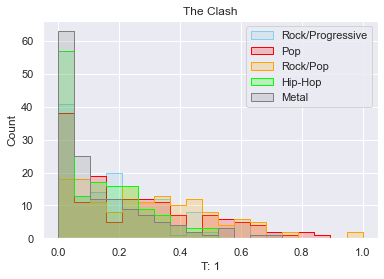

In [152]:
graf_band('The Clash')